In [122]:
import os
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [85]:
interpreter = tf.lite.Interpreter(
    model_path=r"yolov5_results\train\spriteNetv5-maxpix\weights\best-fp16.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(input_details["shape"], input_details["dtype"])
print(output_details["shape"])

[  1 320 320   3] <class 'numpy.float32'>
[   1 6300    6]


In [117]:
folder_path=r"thumbs\NL000K_20230814"
img = "thumbnail_462.bmp"
image_path = os.path.join(folder_path, img)
image = Image.open(image_path).convert("RGB")
original_image = image.copy()
input_shape = input_details["shape"]
image = image.resize((input_shape[1], input_shape[2]))
input_data = np.array(image, dtype=np.float32)
input_data /= 255
if len(input_data.shape) == 3:
    input_data = input_data[None]  # expand for batch dim
print(input_data.shape)
# Set the tensor to point to the input data to be inferred
interpreter.set_tensor(input_details["index"], input_data)

# Run the inference
interpreter.invoke()

# Get the output tensor
prediction = interpreter.get_tensor(output_details["index"])
print(prediction,prediction.shape)

(1, 320, 320, 3)
[[[2.4780868e-02 1.3436830e-02 4.9471028e-02 2.9341143e-02 3.6376761e-04
   9.9998027e-01]
  [2.6240269e-02 1.5655413e-02 5.6090266e-02 3.3641830e-02 2.7331564e-04
   9.9998277e-01]
  [2.8275628e-02 1.4828690e-02 5.9131596e-02 3.1698402e-02 2.8985064e-04
   9.9998778e-01]
  ...
  [9.1449767e-01 8.5155433e-01 1.8056244e-01 4.3897042e-01 2.2947511e-03
   9.9998266e-01]
  [9.1464156e-01 8.5215712e-01 1.8191282e-01 3.9905965e-01 3.0156076e-03
   9.9998593e-01]
  [9.3379450e-01 8.5873902e-01 3.1093445e-01 4.5016554e-01 1.3865998e-03
   9.9998224e-01]]] (1, 6300, 6)


In [99]:
max_nms = 30000
max_wh = 7680

conf_thres = 0.37
iou_thres = 0.45
max_det = 4

In [82]:
def xywh2xyxy(x):
    """Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right."""
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [83]:
def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)
def nms(
   predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, iou in enumerate(ious):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

In [119]:
xc = prediction[..., 4] > conf_thres  # detection candidates mask
output = np.zeros((max_det, 5))

for xi, x in enumerate(prediction):  # for each image
    x = x[xc[xi]]  # detection candidates
    #print(x)
    # Compute conf
    # print(x[:,5])
    x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
    #print(x)
    # calculate box
    box = xywh2xyxy(x[:, :4])
    # find highest confidence among all classes
    conf, j = np.max(x[:, 5:6], 1, keepdims=True), np.argmax(
        x[:, 5:6], 1, keepdims=True
    )
    # print(x[:,5])
    # merge results into one array and filter candidates
    x = np.concatenate((box, conf, j), 1)[np.reshape(conf, -1) > conf_thres]
    #print(x)
    print("Number of boxes:", x.shape[0])
    # sort by confidence
    x = x[np.argsort(x[:, 4])[::-1][:max_nms]]
    print(x)
    # classes (only 1 used here),c= 0
    c = x[:, 5:6] * max_wh
    # boxes (offset by class), scores
    x=x[:,:5]
    #boxes, scores = x[:, :4] + c, x[:, 4]
    # non-max suppression
    i = nms(x, iou_thres)
    print(i)
    #i = i[:max_det]  # limit detections
    
    output = x[i][:max_det]
print(output)

Number of boxes: 2
[[0.83765548 0.62653905 1.00135744 0.99124736 0.40304601 0.        ]
 [0.8316673  0.62252635 1.00354981 0.99608451 0.39037848 0.        ]]
[ True False]
[[0.83765548 0.62653905 1.00135744 0.99124736 0.40304601]]


In [132]:
from IPython.display import display

image = original_image.copy()

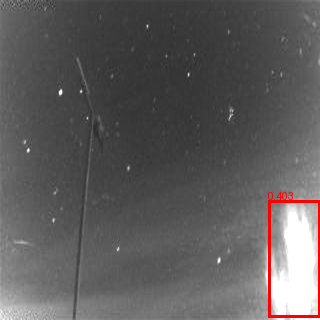

In [133]:
draw = ImageDraw.Draw(image)
# Draw the rectangle
width, height = image.size

top_left = (output[0, 0] * width, output[0, 1] * height)
bottom_right = (output[0, 2] * width, output[0, 3] * height)
draw.rectangle([top_left, bottom_right], outline="red", width=3)
# Display the number above the rectangle
number = str(round(output[0,4],3))
text_position = (top_left[0], top_left[1] - 10)  # Adjust the position as needed
draw.text(text_position, number, fill="red")

# Save or display the modified image
#image.save('path_to_save_modified_image.jpg')
# or
display(image)